In [1]:
import sys
print('python version is',sys.version[:5])

python version is 3.5.2


In [2]:
import numpy as np
X = np.random.random((1000,3))

In [3]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, None, :] - X) ** 2).sum(-1)) # -1 means all axis
%timeit pairwise_numpy(X)

The slowest run took 5.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 46.5 ms per loop


In [4]:
X[:, None, :].shape, X.shape, (X[:, None, :] - X).shape

((1000, 1, 3), (1000, 3), (1000, 1000, 3))

In [5]:
# Pure python function
def pairwise_python(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=np.float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
            
    return D
%timeit pairwise_python(X)

1 loop, best of 3: 3.85 s per loop


In [10]:
from numba import double
from numba.decorators import jit, autojit

pairwise_numba = autojit(pairwise_python)

%timeit pairwise_numba(X)

The slowest run took 64.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 6.05 ms per loop


# Wow, 1000 times!!! numba improved computation time a lot by such a simple method

# Next we try Cython

In [11]:
%load_ext Cython


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [12]:
%%cython

import numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M,M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i,k] - X[j,k]
                d += tmp * tmp
            D[i,j] = sqrt(d)
    return np.asarray(D)


In [13]:
%timeit pairwise_cython(X)

100 loops, best of 3: 6.51 ms per loop


In [14]:
from scipy.spatial.distance import cdist
%timeit cdist(X, X)

100 loops, best of 3: 7.73 ms per loop


In [18]:
from sklearn.metrics import euclidean_distances
%timeit euclidean_distances(X, X)

100 loops, best of 3: 12.2 ms per loop


# Comparing the results

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


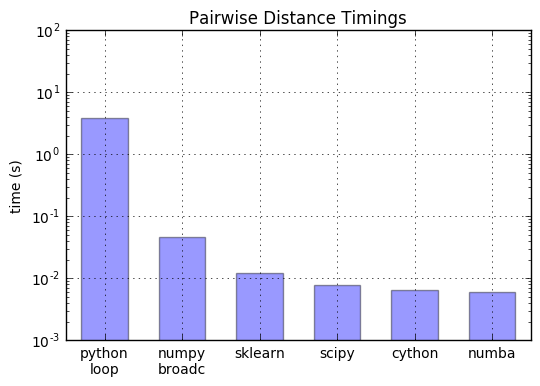

In [24]:
labels = ['python\nloop', 'numpy\nbroadc', 'sklearn', 'scipy', 'cython', 'numba']
timings = [3.85, 0.0465, 0.0122, 0.00773, 0.00651, 0.00605]
x = np.arange(len(labels))

ax = plt.axes(xticks=x, yscale='log')
ax.bar(x - 0.3, timings, width=0.6, alpha=0.4, bottom=1E-6)
ax.grid()
ax.set_xlim(-0.5, len(labels) - 0.5)
ax.set_ylim(1E-3, 1E2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda i, loc: labels[int(i)]))
ax.set_ylabel('time (s)')
ax.set_title('Pairwise Distance Timings')